<a href="https://colab.research.google.com/github/mar2000/Deep-Neural-Networks/blob/main/Project4/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Franciszek Stachura - fs469337

# Exploration strategies for DQN algorithm

In this assignment we are interested in exploration strategies that can be combined with Q-learning.
Q-learning is an off-policy algorithm, which means that the data for the algorithm can be collected by a different policy (called behavioural policy) that the one the algorithm learns.

Here we come across a classical trade-off in reinforcement learning, called exploration-exploitation trade-off. On the one hand, our behavioural policy should try out new state-action pairs to gain knowledge about their returns. On the other hand, when our estimate of returns is good enough, we would like to follow the state-action pairs with the highest estimated returns.

We will be operating on DQN [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) algorithm and analyzing epsilon-greedy strategy, boltzmann and max-boltzmann strategy and combination of epsilon-greedy and boltzmann.
We evaluate performance of DQN variants on the Lunar Lander environment.

We provide an implementation of the DQN algorithm with random exploration strategy.
Your goal is to implement the exploration variants by overriding appropriate methods of the provided class.


## Grading

To obtain the points for the assignment You need to provide the implementation of exploration techniques AND report with plots and conclusions.
Measuring sensitivity means that You should at least examine one reasonably lower and one reasonably greater value of the considered hyperparameter (or the pair of hyperparameters).


1. Implement epsilon-greedy strategy and investigate hyperparameter sensitivity (1 point).
2. Implement epsilon-greedy strategy with epsilon annealing and investigate hyperparameter sensitivity (1 point).
3. Implement boltzmann strategy and investigate hyperparameter sensitivity (1 point).
4. Implement boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
5. Implement max-boltzmann strategy and investigate hyperparameter sensitivity (1 point).
6. Implement max-boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
7. Implement combination of epsilon-greedy with epsilon annealing and boltzmann strategy and investigate hyperparameter sensitivity (1 point)
8. (*) Bonus: propose another reasonable approach to combine epsilon-greedy with epsilon annealing strategy and boltzmann strategy and/or another reasonable strategy of temperature annealing for the boltzmann strategy (2 points).
9. Compare methods, present plots and conclusions in a clear manner (3 points).

You can obtain max 10 points, bonus points increase Your score, if You lose points in some other tasks.

Here we import necessary libraries.

In [ ]:
# @title
!apt-get install swig
!pip install gymnasium[box2d]
!pip install torch

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 2 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (811 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu

In [ ]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy

Here we set hyperparameters of the training, set seeds for reproducibility and set weights initialization.
Although for debugging it might be useful to operate on a smaller number of training_steps, seeds etc., in the final evaluation DO NOT CHANGE these parameters.

In [ ]:
class parse_args:
  def __init__(self):
    self.n_seeds = 6
    self.n_evaluate_episodes = 5
    self.n_training_steps = 100000
    self.buffer_size = 10000
    self.init_steps = 10000
    self.target_update_freq = 50
    self.eval_freq = 1000
    self.gym_id = "LunarLander-v3"
    env = gym.make(self.gym_id)
    self.state_dim = env.observation_space.shape[0]
    self.batch_size = 128
    self.hidden_dim = 128
    self.action_dim = env.action_space.n
    self.discount = 0.99
    self.lr = 7e-4
    self.cuda = True
    self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")

args = parse_args()
first_half_training_args = parse_args()
first_half_training_args.n_training_steps = first_half_training_args.n_training_steps // 2
second_half_training_args = parse_args()
second_half_training_args.n_training_steps = second_half_training_args.n_training_steps // 2
second_half_training_args.init_steps = 1

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

def weight_init(model):
  torch.nn.init.orthogonal_(model.weight.data)
  model.bias.data.fill_(0.0)

Here we implement the replay buffer.
It has two methods: add one transition to the buffer and sample batch of transitions from the buffer.

In [ ]:
class ReplayBuffer:
  def __init__(self, args):
    self.states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.actions = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.rewards = np.zeros((args.buffer_size, args.n_seeds), dtype = np.float32)
    self.next_states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.terminals = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.idx = 0
    self.current_size = 0
    self.args = args

  def add(self, state, action, reward, next_state, terminal):
    if self.current_size < self.args.buffer_size:
      self.current_size += 1
    self.states[self.idx, :, :] = state
    self.actions[self.idx, :] = action
    self.rewards[self.idx, :] = reward
    self.next_states[self.idx, :, :] = next_state
    self.terminals[self.idx, :] = terminal
    self.idx = (self.idx + 1) % self.args.buffer_size

  def sample(self):
    sample_idxs = np.random.permutation(self.current_size)[:self.args.batch_size]
    states = torch.from_numpy(self.states[sample_idxs]).to(self.args.device)
    actions = torch.from_numpy(self.actions[sample_idxs]).to(self.args.device)
    rewards = torch.from_numpy(self.rewards[sample_idxs]).to(self.args.device)
    next_states = torch.from_numpy(self.next_states[sample_idxs]).to(self.args.device)
    terminals = torch.from_numpy(self.terminals[sample_idxs]).to(self.args.device)

    return states, actions, rewards, next_states, terminals


Here we implement a simple Q network architecture with three layers and ReLU activations.

In [ ]:
class QNetwork(torch.nn.Module):
  def __init__(self, args):
    super(QNetwork, self).__init__()
    self.layer_1 = torch.nn.Linear(args.state_dim, args.hidden_dim)
    self.layer_2 = torch.nn.Linear(args.hidden_dim, args.hidden_dim)
    self.layer_3 = torch.nn.Linear(args.hidden_dim, args.action_dim)
    self.relu = torch.nn.ReLU()

    self.layer_1.apply(weight_init)
    self.layer_2.apply(weight_init)
    self.layer_3.apply(weight_init)

  def forward(self, x):
    x = self.relu(self.layer_1(x))
    x = self.relu(self.layer_2(x))
    x = self.layer_3(x)

    return x

Here we provide code for DQN with random exploration.

In [ ]:
TRAIN_SEED = 0
EVAL_SEED = 1

class DQN:
  def __init__(self, args):
    self.args = args
    self.discount = self.args.discount
    self.reset()
    self.annealing = False

  # Copying parameters of other DQN class by reference (for half epsion-greedy, half boltzmann task)
  def copy_reference(self, other):
    self.buffer = other.buffer
    self.q_net = other.q_net
    self.q_target = other.q_target
    self.optimizer = other.optimizer

  # Annealing of epsilon and/or temperature
  def anneal(self, step):
    pass

  # Greedy action
  def get_greedy_action(self, states):
    with torch.no_grad():
      action = torch.argmax(self.q_net(states), dim = -1).detach().cpu().numpy()
      return action

  # Exploration action choice
  def explore(self, states):
    # Random action choice
    action = np.random.randint(self.args.action_dim, size = self.args.n_seeds)
    return action

  # Update of the main critic
  def update(self):
    states, actions, rewards, next_states, terminals = self.buffer.sample()
    with torch.no_grad():
      q_next_states = torch.max(self.q_target(next_states), dim = -1)[0]
    ones_tensor = torch.ones_like(terminals).to(self.args.device)
    targets = rewards + (ones_tensor - terminals) * self.discount * q_next_states

    self.optimizer.zero_grad()
    q_values = self.q_net(states).gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    loss = torch.mean((q_values - targets) ** 2)
    loss.backward()
    self.optimizer.step()

  # Update of the targer critic
  def update_target(self):
    self.q_target.load_state_dict(self.q_net.state_dict())

  # Evaluation of the performance on test environments.
  def evaluate(self):
    eval_results = np.zeros(self.args.n_seeds)
    with torch.no_grad():
      eval_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
      eval_env.reset(seed = EVAL_SEED)
      for _ in range(self.args.n_evaluate_episodes):
        state, info = eval_env.reset()
        episode_reward = np.zeros(self.args.n_seeds)
        mask = np.ones(self.args.n_seeds)
        while np.sum(mask) > 0:
          action = self.get_greedy_action(torch.tensor(state).to(self.args.device))
          next_state, reward, terminal, truncated, _ = eval_env.step(action)
          episode_reward += mask * reward
          state = next_state
          mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
        eval_results += episode_reward / self.args.n_evaluate_episodes
    return np.mean(eval_results), np.std(eval_results)


  # Resetting the algorithm
  def reset(self):
    self.buffer = ReplayBuffer(self.args)
    self.q_net = QNetwork(self.args).to(self.args.device) # main critic
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = self.args.lr, eps = 1e-5)
    self.q_target = QNetwork(self.args).to(self.args.device) # target critic
    self.update_target()

  # Training loop
  def train(self):
    eval_results_means = np.array([])
    eval_results_stds = np.array([])
    train_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
    state, info = train_env.reset(seed = TRAIN_SEED)
    mask = np.ones(self.args.n_seeds)
    print(self.args.n_training_steps)
    for step in range(self.args.n_training_steps):
      #print(state)
      action = self.explore(torch.tensor(state).unsqueeze(0).to(self.args.device))
      if self.annealing:
        self.anneal(step)
      next_state, reward, terminal, truncated, _ = train_env.step(action)
      self.buffer.add(state, action, reward, next_state, terminal)
      state = next_state
      if step % self.args.eval_freq == 0:
          print(f"Training step: {step}")
          eval_mean, eval_std = self.evaluate()
          print(f"Eval mean: {eval_mean}; eval_std: {eval_std}")
          eval_results_means = np.append(eval_results_means, eval_mean)
          eval_results_stds = np.append(eval_results_stds, eval_std)
      if step >= self.args.init_steps:
        self.update()
        if step % self.args.target_update_freq == 0:
          self.update_target()
      mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
      if np.sum(mask) == 0:
        state, info = train_env.reset()
        mask = np.ones(self.args.n_seeds)

    return eval_results_means, eval_results_stds


Here we implement functions for plotting.

In [ ]:
def smooth(data, weigth = 0.9):
  smooth_data = np.copy(data)
  for index in range(1, len(data)):
    smooth_data[index] = smooth_data[index - 1] * weigth + data[index] * (1.0 - weigth)

  return smooth_data

def plot_smooth(args, result_means, result_stds):
  smooth_result_means = smooth(result_means)
  smooth_result_stds = smooth(result_stds)
  print(smooth_result_means)
  print(smooth_result_stds)
  xs = np.arange(len(result_means)) * args.eval_freq
  print(xs)
  plt.plot(xs, smooth_result_means, color = "blue")
  plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, label = "smoothed_rewards")
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_smooth_many(args, result_means_list, result_stds_list, names_list, colours_list):
  plt.figure(figsize=(12.8, 9.6))
  for result_means, result_stds, name, colour in zip(result_means_list, result_stds_list, names_list, colours_list):
    smooth_result_means = smooth(result_means)
    smooth_result_stds = smooth(result_stds)
    print(smooth_result_means)
    print(smooth_result_stds)
    xs = np.arange(len(result_means)) * args.eval_freq
    print(xs)
    plt.plot(xs, smooth_result_means, color = colour)
    plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, color = colour, label = f"smoothed_rewards_{name}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_results(result_mean, result_std):
  plot_smooth(args, result_mean, result_std)

def plot_results_many(result_means_list, result_stds_list, name_list, colours_list):
  plot_smooth_many(args, result_means_list, result_stds_list, name_list, colours_list)


def plot_nonsmooth_many(args, result_means_list, result_stds_list, names_list, colours_list):
  plt.figure(figsize=(12.8, 9.6))
  for result_means, result_stds, name, colour in zip(result_means_list, result_stds_list, names_list, colours_list):
    result_means = np.copy(result_means)
    result_stds = np.copy(result_stds)
    xs = np.arange(len(result_means)) * args.eval_freq
    plt.plot(xs, result_means, color = colour)
    plt.fill_between(xs, result_means - result_stds, result_means + result_stds, alpha = 0.2, color = colour, label = f"smoothed_rewards_{name}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

Here we provide code for training across different random seeds.

In [ ]:
def train_dqn(dqn):
  set_seed(TRAIN_SEED)
  dqn.reset()
  result_mean, result_std = dqn.train()
  print(result_mean)
  return result_mean, result_std


In [ ]:
dqn = DQN(args)
result_means_dqn, result_stds_dqn = train_dqn(dqn)
plot_results(result_means_dqn, result_stds_dqn)

In [ ]:
colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

Here the goal is to implement the epsilon-gredy strategy. With probability epsilon we choose uniformly a random action and with probability 1-epsilon we take the action with the highest Q-value according to the main critic.

In [ ]:
class EpsilonGreedyDQN(DQN):
  def __init__(self, args, epsilon=0.1):
    super(EpsilonGreedyDQN, self).__init__(args)
    self.epsilon = epsilon # investigate sensitivity

  def explore(self, states):
    action_mask = np.random.rand(self.args.n_seeds) <= self.epsilon
    action = np.where(
        action_mask,
        np.random.randint(self.args.action_dim, size = self.args.n_seeds),
        np.argmax(self.q_net(states).cpu().detach().numpy(), axis=-1).squeeze(0)
    )

    return action

In [ ]:
eg_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, epsilon in enumerate([0.1, 0.5, 0.9]):
    eg_results["names"].append(f"epsilon greedy {epsilon}")
    eg_results["colours"].append(colours_list[i])

    epsilon_greedy_dqn = EpsilonGreedyDQN(args, epsilon=epsilon)
    result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn = train_dqn(epsilon_greedy_dqn)
    eg_results["means"].append(result_means_epsilon_greedy_dqn)
    eg_results["stds"].append(result_stds_epsilon_greedy_dqn)

In [ ]:
for i, epsilon in enumerate([0.15, 0.05, 0.01]):
    eg_results["names"].append(f"epsilon greedy {epsilon}")
    eg_results["colours"].append(colours_list[i])

    epsilon_greedy_dqn = EpsilonGreedyDQN(args, epsilon=epsilon)
    result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn = train_dqn(epsilon_greedy_dqn)
    eg_results["means"].append(result_means_epsilon_greedy_dqn)
    eg_results["stds"].append(result_stds_epsilon_greedy_dqn)

In [ ]:
plot_results_many(eg_results["means"], eg_results["stds"], eg_results["names"], eg_results["colours"])

In [ ]:
plot_results_many(eg_results["means"], eg_results["stds"], eg_results["names"], eg_results["colours"])

Here we add to the epsilon-greedy strategy epsilon annealing. We change linearly epsilon from 1.0 to the value final_epsilon during first anneal_steps steps and then it remains on the final_epsilon level.
Such an approach aims to increase the exploration level at the beginning of the training, when the Q-value estimate is poor and thus choosing greedily according to Q is not improving the performance.

In [ ]:
class EpsilonGreedyWithAnnealingDQN(EpsilonGreedyDQN):
  def __init__(self, args, final_epsilon=0.1):
    self.start_epsilon = 1.0
    super(EpsilonGreedyWithAnnealingDQN, self).__init__(args)
    self.epsilon = self.start_epsilon
    self.final_epsilon = final_epsilon # investigate sensitivity
    self.annealing = True
    self.anneal_steps = 30000

  def anneal(self, step):
    if step >= self.anneal_steps:
      self.epsilon = self.final_epsilon
    else:
      self.epsilon = self.start_epsilon - (step*(self.start_epsilon-self.final_epsilon))/self.anneal_steps

  def reset(self):
    super(EpsilonGreedyWithAnnealingDQN, self).reset()
    self.epsilon = self.start_epsilon

In [ ]:
ega_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, final_eps in enumerate([0.1, 0.5, 0.9]):
    ega_results["names"].append(f"epsilon greedy with annealing final eps {final_eps}")
    ega_results["colours"].append(colours_list[i])

    epsilon_greedy_with_annealing_dqn = EpsilonGreedyWithAnnealingDQN(args, final_epsilon=final_eps)
    result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn = train_dqn(epsilon_greedy_with_annealing_dqn)
    ega_results["means"].append(result_means_epsilon_greedy_with_annealing_dqn)
    ega_results["stds"].append(result_stds_epsilon_greedy_with_annealing_dqn)

In [ ]:
for i, final_eps in enumerate([0.15, 0.05, 0.01]):
    ega_results["names"].append(f"epsilon greedy with annealing final eps {final_eps}")
    ega_results["colours"].append(colours_list[i])

    epsilon_greedy_with_annealing_dqn = EpsilonGreedyWithAnnealingDQN(args, final_epsilon=final_eps)
    result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn = train_dqn(epsilon_greedy_with_annealing_dqn)
    ega_results["means"].append(result_means_epsilon_greedy_with_annealing_dqn)
    ega_results["stds"].append(result_stds_epsilon_greedy_with_annealing_dqn)

In [ ]:
plot_results_many(ega_results["means"], ega_results["stds"], ega_results["names"], ega_results["colours"])

In [ ]:
plot_results_many(ega_results["means"], ega_results["stds"], ega_results["names"], ega_results["colours"])

Alternative approach to the epsilon-greedy strategy is to use so-called boltzmann exploration strategy.
The idea behind this approach is to perform softmax on the Q-values coming from the main critic and then sample from the obtained distribution.
In this approach we use softmax with a temperature, i.e. before applying softmax, we scale all the Q-values by the temperature coefficient (in the literature we usually divide by the temperature, but this is equivallent to scaling by the inverse of the temperature). Large scaling values make the distribution close to the greedy choice, while low scaling values make the distribution close to the uniform one.

In [ ]:
class BoltzmannDQN(DQN):
  def __init__(self, args, temperature=0.1):
    super(BoltzmannDQN, self).__init__(args)
    self.temperature = temperature # investigate sensitivity

  def explore(self, states):
    action = None
    with torch.no_grad():
      result = self.q_net(states)
      result = torch.softmax(result * self.temperature, dim=-1)
      action = torch.argmax(result, dim=-1).squeeze(0).cpu().numpy()

    return action

In [ ]:
btz_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, temp in enumerate([0.00001, 0.001, 0.1]): #0.5, 0.9]):
    btz_results["names"].append(f"btz temp {temp}")
    btz_results["colours"].append(colours_list[i])

    #argsn = copy.deepcopy(args)
    #argsn.n_training_steps = 20000
    boltzmann_dqn = BoltzmannDQN(args, temperature=temp)
    result_means_boltzmann_dqn, result_stds_boltzmann_dqn = train_dqn(boltzmann_dqn)
    btz_results["means"].append(result_means_boltzmann_dqn)
    btz_results["stds"].append(result_stds_boltzmann_dqn)

In [ ]:
plot_results_many(btz_results["means"], btz_results["stds"], btz_results["names"], btz_results["colours"])

In [ ]:
for i, temp in enumerate([0.5, 0.9]):
    btz_results["names"].append(f"btz temp {temp}")
    btz_results["colours"].append(colours_list[i])

    #argsn = copy.deepcopy(args)
    #argsn.n_training_steps = 20000
    boltzmann_dqn = BoltzmannDQN(args, temperature=temp)
    result_means_boltzmann_dqn, result_stds_boltzmann_dqn = train_dqn(boltzmann_dqn)
    btz_results["means"].append(result_means_boltzmann_dqn)
    btz_results["stds"].append(result_stds_boltzmann_dqn)

In [ ]:
plot_results_many(btz_results["means"], btz_results["stds"], btz_results["names"], btz_results["colours"])

One of the compromises between epsilon-greedy and boltzmann exploration strategy is so-calles max-boltzmann strategy. In this strategy with probability 1-epsilon we choose action greedily, but with probability epsilon we perform the boltzmann choice instead of the uniform random choice.

In [ ]:
class MaxBoltzmannDQN(EpsilonGreedyWithAnnealingDQN):
  def __init__(self, args, temperature=0.1):
    super(MaxBoltzmannDQN, self).__init__(args)
    self.temperature = temperature # investigate sensitivity

  def explore(self, states):
    action = None
    with torch.no_grad():
      result = self.q_net(states)
      result = torch.softmax(result * self.temperature, dim=-1)
      action_boltzmann = torch.argmax(result, dim=-1).squeeze(0).cpu().numpy()
      action_greedy = np.argmax(self.q_net(states).cpu().detach().numpy(), axis=-1).squeeze(0)

    action = np.where(
        np.random.rand(self.args.n_seeds) <= self.epsilon, # true with prob eps
        action_boltzmann, # prob eps
        action_greedy     # prob 1-eps
    )

    return action

In [ ]:
max_btz_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, temp in enumerate([0.00001, 0.001, 0.1]): #0.5, 0.9]):
    max_btz_results["names"].append(f"max btz temp {temp}")
    max_btz_results["colours"].append(colours_list[i])

    max_boltzmann_dqn = MaxBoltzmannDQN(args, temperature=temp)
    result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn = train_dqn(max_boltzmann_dqn)
    max_btz_results["means"].append(result_means_max_boltzmann_dqn)
    max_btz_results["stds"].append(result_stds_max_boltzmann_dqn)

In [ ]:
plot_results_many(max_btz_results["means"], max_btz_results["stds"], max_btz_results["names"], max_btz_results["colours"])

In [ ]:
for i, temp in enumerate([0.5, 0.9]):
    max_btz_results["names"].append(f"max btz temp {temp}")
    max_btz_results["colours"].append(colours_list[i])

    max_boltzmann_dqn = MaxBoltzmannDQN(args, temperature=temp)
    result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn = train_dqn(max_boltzmann_dqn)
    max_btz_results["means"].append(result_means_max_boltzmann_dqn)
    max_btz_results["stds"].append(result_stds_max_boltzmann_dqn)

In [ ]:
plot_results_many(max_btz_results["means"], max_btz_results["stds"], max_btz_results["names"], max_btz_results["colours"])

Similarly to adjusting the value of epsilon in epsilon-greedy strategy, we can adjust the temperature in the max-boltzmann and boltzmann strategies: we start we the value start_temperature and linearly increase the value to the final_temperature during temperature_anneal_steps, then the temperature is on the constant level.


In [ ]:
class MaxBoltzmannWithTemperatureAnnealingDQN(MaxBoltzmannDQN):
  def __init__(self, args, start_temparature=0.025, final_temperature=0.3):
    self.start_temparature = start_temparature # investigate sensitivity
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temparature
    self.final_temperature = final_temperature # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).anneal(step)
    if step >= self.temperature_anneal_steps:
      self.temperature = self.final_temperature
    else:
      self.temperature = self.start_temparature + (step*abs(self.start_temparature-self.final_temperature))/self.temperature_anneal_steps

  def reset(self):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temparature

In [ ]:
max_btz_temp_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
# length: 0,275, 0,00099, 0,0000475
for i, (start_temp, final_temp) in enumerate([(0.025, 0.3), (0.00001, 0.001), (0.0000025, 0.00005)]):
    max_btz_temp_results["names"].append(f"max btz with temp annealing {start_temp} {final_temp}")
    max_btz_temp_results["colours"].append(colours_list[i])

    max_boltzmann_temp_anneal_dqn = MaxBoltzmannWithTemperatureAnnealingDQN(args, start_temparature=start_temp, final_temperature=final_temp)
    result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn = train_dqn(max_boltzmann_temp_anneal_dqn)
    max_btz_temp_results["means"].append(result_means_max_boltzmann_temp_anneal_dqn)
    max_btz_temp_results["stds"].append(result_stds_max_boltzmann_temp_anneal_dqn)

In [ ]:
plot_results_many(max_btz_temp_results["means"], max_btz_temp_results["stds"], max_btz_temp_results["names"], max_btz_temp_results["colours"])

In [ ]:
for i, (start_temp, final_temp) in enumerate([(0.1, 0.4)]):
    max_btz_temp_results["names"].append(f"max btz with temp annealing {start_temp} {final_temp}")
    max_btz_temp_results["colours"].append(colours_list[i])

    max_boltzmann_temp_anneal_dqn = MaxBoltzmannWithTemperatureAnnealingDQN(args, start_temparature=start_temp, final_temperature=final_temp)
    result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn = train_dqn(max_boltzmann_temp_anneal_dqn)
    max_btz_temp_results["means"].append(result_means_max_boltzmann_temp_anneal_dqn)
    max_btz_temp_results["stds"].append(result_stds_max_boltzmann_temp_anneal_dqn)

In [ ]:
plot_results_many(max_btz_temp_results["means"], max_btz_temp_results["stds"], max_btz_temp_results["names"], max_btz_temp_results["colours"])

In [ ]:
class BoltzmannWithTemperatureAnnealingDQN(BoltzmannDQN):
  def __init__(self, args, start_temparature=0.25, final_temperature=3.0):
    self.start_temparature = start_temparature # investigate sensitivity
    super(BoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temparature
    self.final_temperature = final_temperature # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    super(BoltzmannWithTemperatureAnnealingDQN, self).anneal(step)
    if step >= self.temperature_anneal_steps:
      self.temperature = self.final_temperature
    else:
      self.temperature = self.start_temparature + (step*abs(self.start_temparature-self.final_temperature))/self.temperature_anneal_steps

  def reset(self):
    super(BoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temparature

In [ ]:
btz_temp_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, (start_temp, final_temp) in enumerate([(0.025, 0.3), (0.00001, 0.001), (0.0000025, 0.00005)]):
    btz_temp_results["names"].append(f"btz with temp annealing {start_temp} {final_temp}")
    btz_temp_results["colours"].append(colours_list[i])

    boltzmann_temp_anneal_dqn = BoltzmannWithTemperatureAnnealingDQN(args, start_temparature=start_temp, final_temperature=final_temp)
    result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn = train_dqn(boltzmann_temp_anneal_dqn)
    btz_temp_results["means"].append(result_means_boltzmann_temp_anneal_dqn)
    btz_temp_results["stds"].append(result_stds_boltzmann_temp_anneal_dqn)

In [ ]:
plot_results_many(btz_temp_results["means"], btz_temp_results["stds"], btz_temp_results["names"], btz_temp_results["colours"])

In [ ]:
for i, (start_temp, final_temp) in enumerate([(0.25, 3), (0.5, 5)]):
    btz_temp_results["names"].append(f"btz with temp annealing {start_temp} {final_temp}")
    btz_temp_results["colours"].append(colours_list[i])

    boltzmann_temp_anneal_dqn = BoltzmannWithTemperatureAnnealingDQN(args, start_temparature=start_temp, final_temperature=final_temp)
    result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn = train_dqn(boltzmann_temp_anneal_dqn)
    btz_temp_results["means"].append(result_means_boltzmann_temp_anneal_dqn)
    btz_temp_results["stds"].append(result_stds_boltzmann_temp_anneal_dqn)

In [ ]:
plot_results_many(btz_temp_results["means"], btz_temp_results["stds"], btz_temp_results["names"], btz_temp_results["colours"])

The last exploration idea we want to implement is a combintation of the epsilon-greedy strategy (with epsilon annealing) and the boltzmann strategy.
We could think that at the beginning of the training the boltzmann strategy struggles because the Q-function (the main critic) is not yet well-trained. However, the more critic is trained, the more sense it makes to start using the boltzmann strategy. We would like to verif y this hypoothesis by using in the first half of the training epsilon-greedy strategy (with epsilon annealing) and in the second half of the training switch the exploration strategy to the boltzmann one.

In [ ]:
def train_two_halfs_dqn(dqn_1, dqn_2):
  try:
    set_seed(TRAIN_SEED)
    dqn_1.reset()
    dqn_2.reset()
    args1 = dqn_1.args
    args2 = dqn_2.args

    dqn_1.args = first_half_training_args
    print(dqn_1.args.n_training_steps)
    result_mean_1, result_std_1 = dqn_1.train()
    print("dqn 1", result_mean_1)

    dqn_2.copy_reference(dqn_1)
    dqn_2.args = second_half_training_args
    print(dqn_2.args.n_training_steps)
    result_mean_2, result_std_2 = dqn_2.train()
    print("dqn 2", result_mean_2)

    result_mean = np.concat((result_mean_1, result_mean_2))
    result_std = np.concat((result_std_1, result_std_2))
  finally:
    dqn_1.args = args1
    dqn_2.args = args2

  return result_mean, result_std


In [ ]:
halves_results = {"means": [], "stds": [], "names": [], "params": [], "colours": []}

In [ ]:
for i, (eps, temp) in enumerate([(0.1, 0.00001), (0.1, 0.001), (0.5, 0.00001), (0.1, 1.0), (0.5, 5.0)]):
    halves_results["names"].append(f"halves {eps} {temp}")
    halves_results["colours"].append(colours_list[i])

    epsilon_greedy_with_annealing_half_dqn = EpsilonGreedyWithAnnealingDQN(first_half_training_args, final_epsilon=eps) # investigate sensitivity of epsilon
    epsilon_greedy_boltzmann_half_dqn = BoltzmannDQN(second_half_training_args, temperature=temp) # investigate sensitivity of temperature
    result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn = train_two_halfs_dqn(epsilon_greedy_with_annealing_half_dqn, epsilon_greedy_boltzmann_half_dqn)
    halves_results["means"].append(result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)
    halves_results["stds"].append(result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)


[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -585.65376642 -539.66712089 -501.00182833 -469.55461294
 -435.97165087 -407.6529889  -374.49893143 -341.38139504 -308.82470189
 -278.5224411  -250.17396848 -225.10585156 -201.53529262 -181.45612452
 -160.49556644 -142.40645019 -118.79687699  -99.54643466  -74.99256506
  -50.88174399  -23.82376117   -1.74311065   21.28117963   38.78240652
   60.45158859   81.49551552   99.36290043  111.69577211  124.51653608
  132.04728006  138.81602112  150.17867767  160.97921474  167.60153301
  173.82375617  180.55784288  188.28010228  195.60476118  203.75397465
  210.81427087  216.46169432  221.93440188  223.98323563  227.56938114
  232.10560916  233.13216919  233.56760163  234.34289108  233.86054083
  230.3082991   233.61391187  236.01277517  238.33975733  242.22686225
  246.03334419  247.70313388  248.9217374   251.46121702  251.87388313
  251.

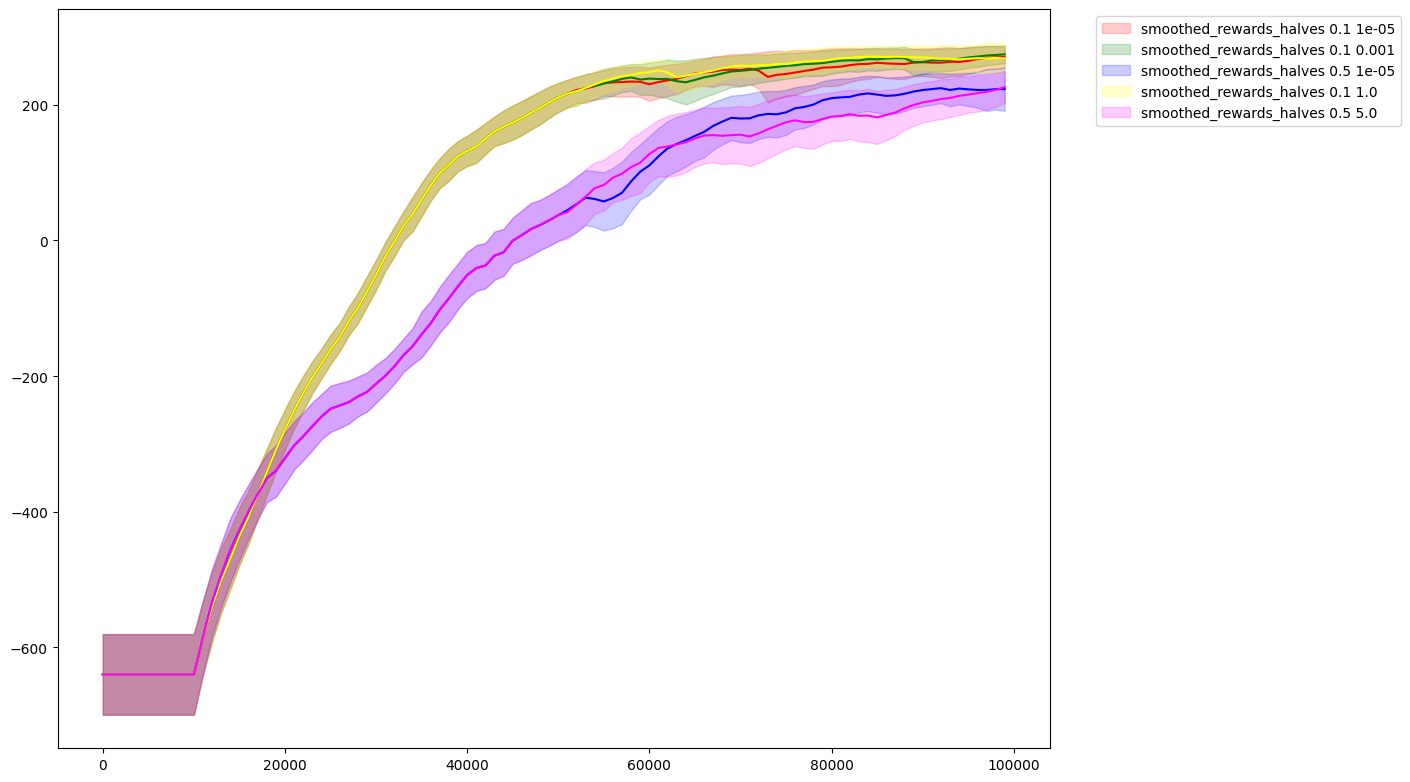

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_results_many(halves_results["means"], halves_results["stds"], halves_results["names"], halves_results["colours"])

Here we plot the results of all exploration methods on one plot. However, for drawing conclusions, it might be reasonable to plot some subsets of methods together, for example to compare variants with and without annealing, max-boltzmann with boltzmann, epsilon-greedy, boltzmann and half-epsilon-greedy, half-boltzmann.

In [ ]:
result_means_list = []
result_stds_list = []
names_list = []

means = []
stds = []
names = []

In [ ]:
# @title
# NOTE: backup values of best reward curves. Full plots are available in the report.

names.append("epsilon greedy eps 0.15")
means.append(
[-639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -583.34339406, -504.00468759, -457.0956254 , -414.62300132,
 -378.27912728, -349.283999  , -318.76170695, -284.29166766, -252.21741093,
 -219.34225346, -202.35024557, -176.34683933, -159.30583477, -137.63525174,
 -119.14080187, -106.98451672,  -91.09219472,  -78.34476427,  -57.7995461 ,
  -54.59062431,  -25.89678567,   -9.33739174,   15.37638831,   32.22719758,
   53.41654592,   70.91141479,   87.66424924,  101.96064015,  114.01530138,
  124.29728619,  136.45592642,  145.78256409,  152.70547135,  159.78289585,
  165.65412303,  174.49030471,  182.96476119,  191.55615038,  198.47545034,
  199.87926369,  204.0093155 ,  210.58692271,  215.97109441,  219.61949521,
  218.54855511,  218.7919161 ,  214.25853719,  217.21981821,  220.98212832,
  225.66474284,  226.81725598,  221.75714355,  225.18739597,  227.23407771,
  229.46389192,  231.1602064 ,  231.54535264,  234.59325065,  235.83348669,
  237.08652996,  237.91446088,  235.59129001,  237.3305586 ,  238.46104234,
  239.65376609,  240.3073946 ,  240.06282315,  243.21997198,  245.1452361 ,
  244.65277121,  244.43900176,  244.04902471,  246.12172492,  247.64091158,
  245.64887117,  248.02074906,  246.88510916,  248.59729459,  245.10149362,
  246.87509841,  248.99686133,  248.83456054,  251.07100588,  252.57464909,
  254.6178656 ,  251.8885586 ,  253.02388613,  249.8965256 ,  250.65288144,])
stds.append(
[59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 54.53913907,
 50.68410669, 46.53396206, 48.67679953, 44.67547977, 40.91207564, 38.10559852,
 37.81056962, 40.89559022, 42.8506936 , 41.21796397, 41.02846617, 39.92357689,
 40.68148959, 40.19684626, 41.82706975, 43.93797753, 45.95595843, 44.52997279,
 44.9007781 , 42.31539532, 45.18835788, 42.05286403, 40.93476218, 37.92667306,
 36.60806806, 34.18371259, 31.86017868, 32.20672863, 32.50037679, 31.07855324,
 30.25431553, 30.64529871, 30.07142801, 30.86229614, 28.64345561, 26.53332375,
 24.79738008, 22.95481425, 23.87296904, 23.06483699, 21.6181111 , 20.48602422,
 19.43348806, 23.00056127, 25.08342875, 25.67953547, 24.884744  , 24.55244039,
 22.75979661, 23.39223386, 24.35212269, 23.06018304, 22.57725317, 23.24216827,
 25.23353295, 25.39133684, 23.71675566, 23.41951231, 24.99976358, 23.97649418,
 25.57641769, 24.97899578, 24.70275298, 24.6917918 , 25.56694805, 27.37448429,
 25.91522035, 25.19158832, 24.51769738, 25.56532564, 27.77749179, 26.06042125,
 24.47484309, 24.24563628, 22.29486032, 22.47580465, 20.92380334, 21.62950959,
 21.88407534, 20.4459005 , 22.10781868, 20.33209513, 19.21145514, 18.19448179,
 21.4089556 , 21.70798745, 22.86704136, 23.68587912,])

names.append("epsilon greedy with annealing final eps 0.05")
means.append(
[-639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -587.42986932, -537.76659637, -498.70658645, -454.49079963,
 -417.20957448, -382.40386637, -356.73036403, -333.24729763, -320.20043246,
 -303.13646671, -273.94229657, -247.48094324, -221.84681435, -193.8549363 ,
 -157.40098298, -124.45595574,  -99.97619336,  -77.36542622,  -56.75575473,
  -35.42736269,  -16.67404662,   -0.80829814,   22.89751528,   42.17529149,
   63.15883993,   80.07954589,   92.80729049,  103.02028817,  118.02157807,
  125.03770949,  134.44593793,  141.71099501,  146.99128201,  158.45707812,
  165.52557266,  170.01551829,  175.53388838,  183.76114842,  190.19594008,
  194.30126057,  200.80329955,  206.23842548,  208.95321167,  210.72224576,
  216.1406727 ,  216.02663246,  212.25513635,  215.53917372,  219.06611041,
  216.22482872,  221.88356847,  226.79853318,  231.28540362,  230.99935633,
  232.96767292,  234.02476614,  237.1153939 ,  240.2119284 ,  244.20375977,
  246.44032072,  246.17192719,  248.83307841,  248.25971782,  250.85100357,
  253.22080544,  253.71091968,  255.08876903,  255.51420507,  256.45113644,
  257.30939719,  257.0756931 ,  257.00190143,  253.63484436,  254.34970964,
  252.42222986,  249.7476963 ,  249.77835113,  249.5109487 ,  246.54400862,
  246.38792733,  245.78050253,  246.87521643,  249.4465539 ,  252.76172642,
  255.36138051,  257.43304237,  259.78064421,  261.85528491,  263.88981179,])
stds.append(
[59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 54.31368362,
 49.66165443, 45.65888318, 47.10021687, 44.25798055, 43.7074126 , 43.00029081,
 44.19027108, 43.32531247, 40.76900088, 37.16672646, 37.20793046, 37.10909834,
 37.72335138, 38.0376303 , 37.31455134, 38.00834744, 36.70242484, 40.85254426,
 40.53455264, 42.31547589, 43.88206647, 41.26101506, 42.0435095 , 39.19347004,
 38.66135781, 40.1438594 , 39.45704057, 37.52137755, 35.91993747, 34.26138953,
 35.05331194, 33.657785  , 32.35376814, 31.54849414, 31.73737741, 32.59903763,
 31.08494152, 30.28041352, 29.00992665, 27.67660842, 26.87317897, 31.40103229,
 34.94991844, 32.32920311, 32.8413001 , 37.13442182, 35.52285598, 34.44639396,
 41.49274789, 37.97342989, 35.2841668 , 32.27495477, 32.68569164, 31.5889453 ,
 30.93124393, 30.40660749, 28.83391725, 26.6679687 , 25.44768791, 25.20981439,
 24.05228257, 24.13506088, 22.94514511, 22.2116316 , 20.95048425, 19.94475193,
 19.60637538, 18.70791529, 18.46065004, 18.94492214, 19.56267512, 21.4374085 ,
 21.14616107, 22.63081294, 24.36245182, 25.0617588 , 25.36302395, 26.01788012,
 25.03570348, 24.66364253, 24.12824892, 23.30898031, 21.86922665, 20.38555146,
 19.46680833, 18.10739593, 17.38112401, 16.02245164,])

names.append("btz temp 1e-5")
means.append([
 -6.39690348e+02, -6.39690348e+02, -6.39690348e+02, -6.39690348e+02,
 -6.39690348e+02, -6.39690348e+02, -6.39690348e+02, -6.39690348e+02,
 -6.39690348e+02, -6.39690348e+02, -6.39690348e+02, -5.73626293e+02,
 -5.55015209e+02, -5.23235976e+02, -4.79249011e+02, -4.31592135e+02,
 -4.06354064e+02, -3.85220611e+02, -3.61759961e+02, -3.33005495e+02,
 -3.15086223e+02, -2.98772600e+02, -2.82141631e+02, -2.67177066e+02,
 -2.50255224e+02, -2.34738292e+02, -2.22068684e+02, -2.15040168e+02,
 -2.02229258e+02, -2.06909905e+02, -2.02722517e+02, -1.92159739e+02,
 -1.83873640e+02, -1.75380690e+02, -1.66364480e+02, -1.58165951e+02,
 -1.51068472e+02, -1.45160073e+02, -1.42307873e+02, -1.38919028e+02,
 -1.33975239e+02, -1.33853361e+02, -1.29282307e+02, -1.25760240e+02,
 -1.21906866e+02, -1.18529325e+02, -1.12349279e+02, -1.10543998e+02,
 -1.06810240e+02, -1.04031404e+02, -1.01474576e+02, -1.06670997e+02,
 -1.06288769e+02, -1.04281385e+02, -1.03829396e+02, -1.01427615e+02,
 -9.84636758e+01, -9.67938057e+01, -9.29300718e+01, -9.19102998e+01,
 -8.72644262e+01, -8.27335340e+01, -7.76240099e+01, -7.60230188e+01,
 -7.44181886e+01, -6.66430856e+01, -6.29437190e+01, -5.82993299e+01,
 -4.86224920e+01, -2.55280949e+01, -2.00399108e+01, -7.86742866e+00,
 -4.43446568e-01,  7.47371237e+00,  1.44293496e+01,  3.14689452e+01,
  3.64051280e+01,  4.98148449e+01,  6.32320567e+01,  7.40423501e+01,
  7.85319168e+01,  9.60654249e+01,  1.06115784e+02,  1.17696184e+02,
  1.30787670e+02,  1.37036776e+02,  1.40011131e+02,  1.48107258e+02,
  1.56536645e+02,  1.61289217e+02,  1.67038989e+02,  1.69114714e+02,
  1.62955736e+02,  1.66531699e+02,  1.73619316e+02,  1.77923004e+02,
  1.85396063e+02,  1.90707322e+02,  1.96388301e+02,  2.01345215e+02,
])
stds.append([
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 56.08759104,
 57.0791772 , 56.65413424, 53.8026238 , 49.30115102, 45.78288314, 42.96878726,
 40.45179118, 40.36697745, 36.87071356, 34.08062309, 31.57265926, 29.4691029 ,
 28.81739539, 29.76102271, 31.01064409, 29.81456035, 28.56043276, 29.03760295,
 27.4363866 , 25.67903888, 23.99942459, 22.50350137, 21.1488754 , 20.00401016,
 18.9454845 , 17.91145458, 18.47922651, 17.43136209, 18.83232883, 22.14240426,
 20.9151927 , 19.87293669, 19.210047  , 18.31176974, 18.17153188, 19.19834418,
 19.51755759, 20.09511783, 20.10870892, 23.24768619, 25.90354262, 25.31752081,
 25.05717293, 24.67780677, 24.01672361, 22.85044244, 21.83387199, 21.11410392,
 23.31802635, 24.73564943, 25.90887885, 26.04943718, 26.71999893, 33.11070862,
 33.95452066, 33.91035864, 32.62121145, 32.71494369, 35.72552965, 39.56023179,
 48.9307453 , 50.52637172, 54.02483494, 53.77590232, 58.35192774, 61.24570337,
 61.53381046, 58.73905464, 59.45505718, 55.09581036, 53.40140976, 51.17382677,
 48.50008059, 46.99772378, 46.00537712, 45.27852904, 44.50288027, 43.70728475,
 43.26226578, 44.82842095, 51.81099159, 50.24726282, 48.21972465, 47.25584207,
 43.91249237, 41.33985425, 39.41654793, 38.92842518,
])

names.append("btz with temp annealing 0.00001 0.001")
means.append(
[-639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -570.96939846, -519.46180044, -487.00927325, -457.87662049,
 -429.7159188 , -400.20060205, -373.58049937, -355.96347912, -346.802683  ,
 -331.54156727, -318.37028626, -306.80189634, -295.01154181, -283.69530252,
 -269.41116591, -261.55379993, -258.27759812, -250.94569103, -246.4324836 ,
 -233.02771382, -225.55090492, -219.4140057 , -213.63009244, -208.9413948 ,
 -199.40259399, -192.64702543, -179.40695773, -173.09079178, -170.58159347,
 -165.47545559, -162.2964109 , -158.76995892, -146.93211391, -133.02277263,
 -114.77814828,  -92.09112748,  -75.94194303,  -56.06291794,  -36.51983272,
  -19.53331607,   -9.67246043,   11.81334476,   21.96713157,   33.44016674,
   47.65096669,   58.13759344,   73.66629749,   88.51913272,   99.26169797,
  111.53011563,  123.32563418,  131.81747456,  138.41513013,  147.37094843,
  148.04804149,  150.95160284,  153.17800484,  154.58876357,  160.6920192 ,
  153.01694257,  162.53470539,  171.42101447,  173.98843239,  174.50943051,
  179.18390678,  183.65112363,  184.61862734,  182.49240897,  187.27539963,
  187.79772685,  188.16010451,  195.36397401,  197.56194226,  192.91272504,
  191.66523654,  194.91322621,  190.25069581,  191.96449717,  192.25495142,
  197.90467937,  203.06030579,  204.25745294,  208.74542554,  205.54348895,
  207.42392322,  198.28721519,  200.86536992,  202.87653657,  208.65221229,
])
stds.append(
[59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 56.91210877,
 52.26057084, 50.62607565, 47.34082605, 44.25452201, 40.6465534 , 38.30523731,
 38.81772542, 37.99113758, 35.96136395, 34.48523678, 32.12935821, 29.70357276,
 27.60637829, 25.66996108, 24.18719451, 24.05966855, 23.37465816, 22.70433579,
 21.19033992, 20.49972797, 19.21594146, 18.2363408 , 17.62805403, 19.19642937,
 20.01303479, 20.12806384, 20.26458788, 21.36979007, 21.37741919, 20.97845198,
 23.15143823, 28.29452728, 31.49529633, 33.59485078, 36.94231895, 37.7866358 ,
 44.50318353, 43.90132986, 43.90577658, 43.24006717, 40.77701325, 44.38940128,
 43.69132041, 44.85985607, 42.90518433, 39.52781168, 39.25107766, 40.84939207,
 39.00357317, 37.0486644 , 36.04724002, 35.52845043, 33.87981068, 33.77718015,
 33.46269534, 34.83486543, 35.73538621, 35.01604545, 36.98424661, 34.62492701,
 31.92302585, 33.49537273, 32.61011864, 32.26983058, 31.92574351, 32.39110955,
 34.21593488, 34.02427552, 33.16908781, 32.22656293, 30.10745868, 32.17053648,
 34.40629338, 36.55232114, 37.73888522, 37.23648931, 37.60157862, 37.61766888,
 37.39208538, 35.8397209 , 33.54760745, 31.41250669, 30.49813051, 30.55509121,
 32.36429681, 33.25041655, 34.12678983, 31.88105437,
])

names.append("max btz temp 1e-3")
means.append([
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -572.96426058, -520.88432721, -474.77477541, -433.95880594,
 -407.24471304, -393.26009711, -360.77325981, -332.68915523, -304.74017559,
 -291.59507946, -271.57679831, -254.29006594, -237.05543117, -227.30645044,
 -209.44019811, -194.36380858, -184.11668484, -175.4420182 , -187.07759225,
 -184.27885348, -166.90993691, -156.71310864, -145.5140903 , -134.70392504,
 -127.4906909 , -123.72170816, -115.46319443, -108.12067727, -100.27413092,
 -101.18480596,  -95.78992706,  -94.80317741,  -93.71293541,  -90.18803818,
  -87.93748382,  -83.41894605,  -77.60871911,  -70.67746877,  -64.55070468,
  -59.94948452,  -60.43273532,  -58.3149396 ,  -54.56392057,  -52.14116607,
  -48.22707807,  -42.02939375,  -33.72522008,  -31.55437692,  -26.45862511,
  -12.38548246,   -2.82227462,   -2.98996236,   15.22312207,   33.38034091,
   43.27356555,   15.65301988,    8.78129505,    8.91808732,   19.98265134,
   34.3843153 ,   56.18044437,   72.50157596,   86.98023244,   97.00791345,
  113.325169  ,  125.45249776,  122.8984998 ,  107.65313889,  121.19106237,
  122.15263577,  134.45226502,  144.82887277,  155.41063952,  165.94954488,
  175.86655858,  183.99875035,  188.34323357,  189.00596853,  196.8804209 ,
  203.43555791,  207.75272086,  205.91233733,  203.24432157,  207.13587103,
  204.68420371,  204.66685916,  205.16528904,  210.03071246,  216.99797136,
])
stds.append([
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 56.43410028,
 57.11520978, 59.67581824, 54.91037979, 51.12784656, 48.01112707, 44.38789541,
 43.02702955, 41.81799268, 41.25346117, 39.95161399, 36.59285509, 33.74005219,
 31.81636153, 29.77219434, 28.11340596, 27.14975772, 26.68620472, 29.74762377,
 28.30277898, 29.50723812, 28.59016647, 27.41966622, 26.34461169, 26.19376028,
 25.53176949, 24.27591815, 22.84485581, 22.22276325, 23.62054066, 24.44830314,
 27.08639797, 27.0848906 , 25.76554633, 24.75832932, 25.33799423, 24.43180788,
 22.93906044, 21.28583139, 20.36210655, 19.71704087, 18.81860893, 18.35483363,
 17.24997317, 16.16282013, 15.71165454, 16.27804425, 15.48965843, 15.43460673,
 19.13541983, 19.64354105, 20.96756201, 21.72033203, 22.09309558, 23.46607874,
 32.05750612, 30.72911094, 33.32603457, 33.90147021, 31.5468811 , 30.53046431,
 31.830343  , 30.84006535, 31.49797421, 29.60779021, 30.93404603, 35.51732735,
 36.11500111, 35.58489422, 37.0551279 , 34.01781249, 31.83041452, 30.86426449,
 29.05740679, 28.22702812, 26.830591  , 26.38182738, 31.63974707, 30.25340682,
 28.71152176, 28.21571788, 31.38657523, 37.32606683, 35.03343092, 36.63812695,
 38.29516336, 38.98412954, 36.77006319, 33.55574561,
])

names.append("max btz with temp annealing 0.0000025 0.00005")
means.append([
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -580.23905001, -544.82137101, -538.26101395, -502.23090915,
 -463.96522727, -435.62580362, -411.36971446, -388.64301408, -371.3368441 ,
 -347.47147876, -337.40549782, -310.76128616, -289.44070421, -263.56275239,
 -247.26680848, -220.64104339, -201.80097395, -189.25841403, -190.58151279,
 -189.06739053, -184.54523094, -180.22125448, -180.87650007, -172.72377163,
 -162.16985038, -152.20744211, -147.35304051, -131.64160902, -127.17960832,
 -121.45477017, -113.76722916, -110.96611999, -118.98982767, -109.83250366,
 -102.1467442 ,  -88.16810379,  -83.1644878 ,  -74.96751472,  -58.02662874,
  -43.02705383,  -32.81295535,  -25.90416147,  -26.2162392 ,  -10.45116321,
    0.98250149,   18.32208884,   35.02998751,   48.12498314,   60.70557297,
   66.74668441,   78.57347877,   92.81221956,  103.97485083,  114.72036579,
  128.49262302,  135.61693901,  145.00429107,  156.46977443,  167.26153398,
  176.23410867,  182.5215525 ,  189.32338904,  196.19016155,  203.52646037,
  208.43629747,  213.20083208,  216.60395679,  218.93948226,  223.2609122 ,
  227.14918469,  230.120897  ,  233.94091518,  235.42324991,  235.78826605,
  236.34727103,  237.49671704,  240.03944223,  241.47170969,  241.8609704 ,
  242.61038347,  240.33642512,  240.477716  ,  241.91049309,  244.14962105,
  246.65375654,  249.57444077,  250.89384514,  251.25926075,  252.30049358,
])
stds.append([
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 60.4177172 ,
 66.81236131, 68.3498027 , 63.58350668, 59.63049298, 54.40507927, 51.5839708 ,
 47.58050889, 46.10609572, 43.7358026 , 41.34956688, 39.48275497, 36.40162637,
 33.56896344, 31.18126046, 31.40775719, 36.08296216, 35.49251855, 34.47955506,
 34.33248912, 36.27725052, 34.99382327, 33.4881113 , 35.43469481, 35.3223113 ,
 34.61425159, 33.10768327, 32.91208348, 31.84697503, 30.04501842, 29.47821119,
 27.51786621, 31.15171947, 30.35957244, 31.82720805, 33.22519313, 37.32978299,
 36.41606044, 35.63663501, 37.17203693, 37.91598351, 39.35218349, 42.14797274,
 41.35077732, 43.19823977, 44.95344305, 45.54250658, 46.19931859, 45.01988268,
 43.96460518, 46.03196545, 43.96370865, 43.07884472, 43.55859275, 41.99746752,
 40.29885741, 39.57189474, 36.83369516, 33.97303137, 32.24954276, 31.15728548,
 30.39065613, 29.10223823, 27.10899942, 26.30142624, 25.83442712, 24.82020693,
 25.71788455, 24.90337197, 23.55347337, 22.75136076, 21.57438018, 20.50212567,
 20.63201063, 23.03438709, 22.66222548, 21.29316538, 21.92059512, 22.32018557,
 23.23735643, 24.07976735, 24.66626812, 24.08570058, 23.809383  , 22.3234456 ,
 20.95205433, 20.75945453, 20.16280575, 20.50436321,
])


names.append("halves 0.1 1.0")
means.append(
[-639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -639.69034775, -639.69034775, -639.69034775, -639.69034775,
 -639.69034775, -585.65376642, -539.66712089, -501.00182833, -469.55461294,
 -435.97165087, -407.6529889 , -374.49893143, -341.38139504, -308.82470189,
 -278.5224411 , -250.17396848, -225.10585156, -201.53529262, -181.45612452,
 -160.49556644, -142.40645019, -118.79687699,  -99.54643466,  -74.99256506,
  -50.88174399,  -23.82376117,   -1.74311065,   21.28117963,   38.78240652,
   60.45158859,   81.49551552,   99.36290043,  111.69577211,  124.51653608,
  132.04728006,  138.81602112,  150.17867767,  160.97921474,  167.60153301,
  173.82375617,  180.55784288,  188.28010228,  195.60476118,  203.75397465,
  210.81427087,  216.51379078,  220.03954473,  224.90361706,  230.10791835,
  234.99626129,  238.76514919,  242.10589243,  243.94831067,  247.03230206,
  248.02025036,  250.93873839,  247.7451354 ,  240.53619056,  243.02713346,
  245.47389836,  248.00128123,  250.68416246,  253.91636722,  256.10246702,
  257.97322634,  257.13157355,  258.39482204,  258.31007199,  260.25973705,
  260.0852756 ,  262.25385761,  263.77253704,  264.64010327,  265.04333421,
  267.11824055,  269.0628495 ,  269.23214385,  270.39220169,  271.13555391,
  271.01014988,  270.3254173 ,  270.97122596,  270.54557782,  270.08557406,
  269.86783699,  268.90423553,  267.83801435,  267.93706434,  267.07572306,
  267.89834837,  268.65833456,  268.40262209,  269.04908173,  268.59717412,])
stds.append(
[59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171,
 59.38467171, 59.38467171, 59.38467171, 59.38467171, 59.38467171, 54.2992901 ,
 51.46688211, 47.62645146, 44.17594241, 42.12310841, 39.35555391, 36.7225286 ,
 34.01401631, 31.83702471, 29.34262675, 27.31793409, 25.43379321, 23.48092771,
 21.86035788, 21.54876613, 20.60836066, 20.80120622, 22.23256337, 22.21293537,
 21.98834675, 21.16471089, 21.65640856, 21.06563085, 25.32950834, 24.18519479,
 22.81350577, 22.00031095, 23.65380608, 22.21391504, 22.32117618, 24.33001069,
 22.84694522, 21.72882393, 24.06406777, 25.19681596, 25.05105624, 24.55127142,
 24.31459836, 22.94230776, 21.49286447, 20.41803635, 21.2219733 , 19.9876649 ,
 18.56699062, 17.85250083, 17.17851682, 16.52863683, 15.68866549, 15.55281175,
 17.1642344 , 16.50147943, 18.51705163, 21.67831266, 20.96659895, 20.12264126,
 19.58062243, 18.45263275, 17.09860668, 16.08787525, 15.26515825, 15.51624043,
 15.77033015, 17.85506948, 16.77534135, 20.29146709, 18.84309777, 18.33310881,
 18.68385466, 19.28158472, 17.89516798, 16.93676504, 16.442581  , 16.15034053,
 15.13244702, 15.60591268, 15.96600676, 16.14514899, 16.92926428, 17.65057877,
 16.82399519, 17.39010432, 20.4044064 , 20.22732663, 19.9987947 , 19.89383833,
 20.11808885, 23.21810567, 22.00994357, 22.47205713,])


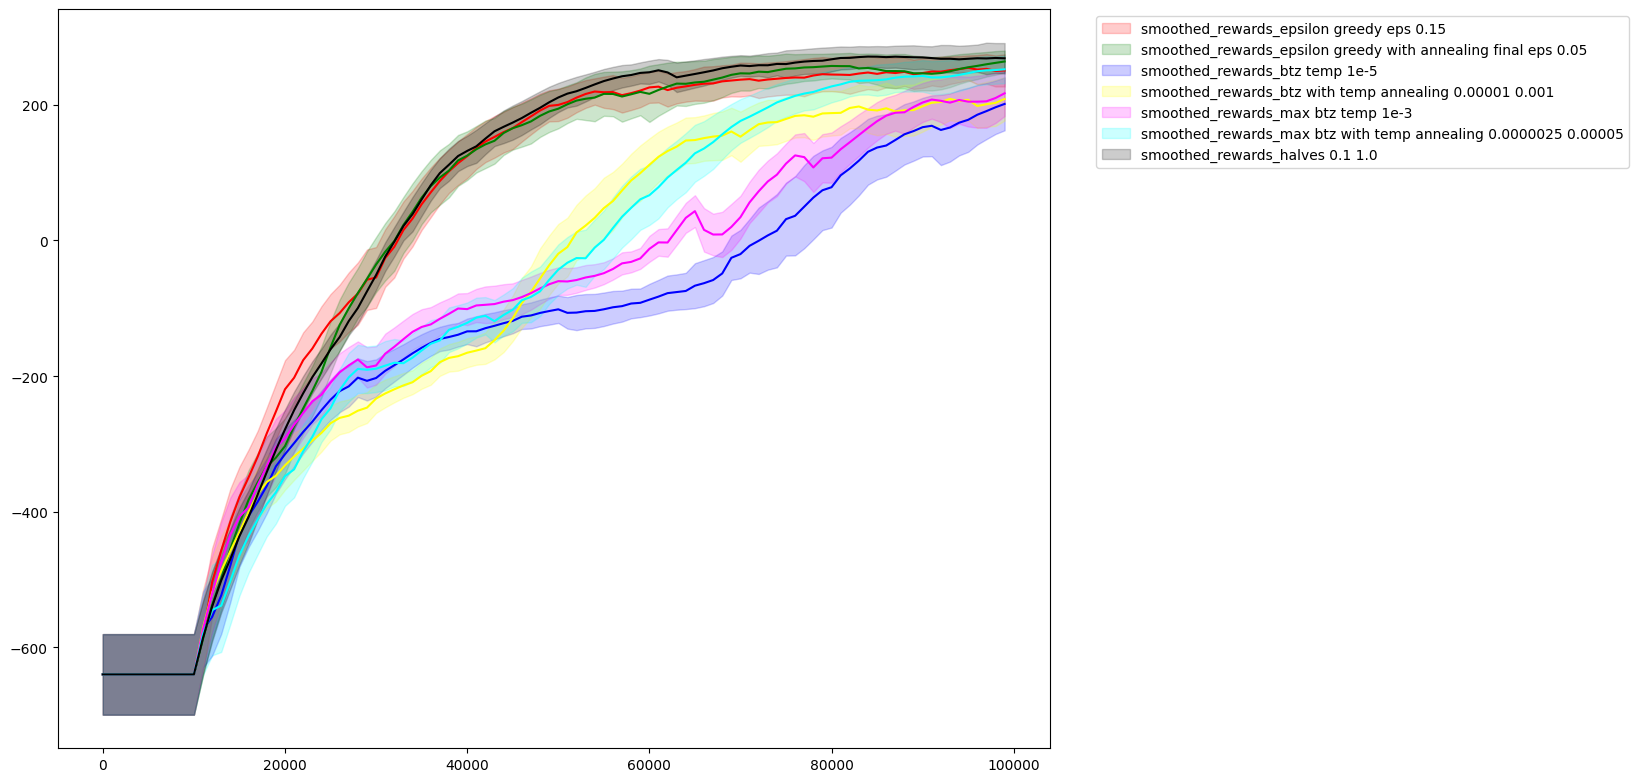

<Figure size 640x480 with 0 Axes>

In [ ]:
#result_means_list = [result_means_dqn, result_means_epsilon_greedy_dqn, result_means_epsilon_greedy_with_annealing_dqn,
#                result_means_boltzmann_dqn, result_means_boltzmann_temp_anneal_dqn,
#                result_means_max_boltzmann_dqn, result_means_max_boltzmann_temp_anneal_dqn,
#                result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
#result_stds_list = [result_stds_dqn, result_stds_epsilon_greedy_dqn, result_stds_epsilon_greedy_with_annealing_dqn,
#                result_stds_boltzmann_dqn, result_stds_boltzmann_temp_anneal_dqn,
#                result_stds_max_boltzmann_dqn, result_stds_max_boltzmann_temp_anneal_dqn,
#                result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
#names_list = ["random", "epsilon-greedy", "epsilon-greedy-with-annealing",
#             "boltzmann", "boltzmann-with-annealing",
#             "max-boltzmann", "max-boltzmann-with-annealing",
#             "half-epsilon-greedy-with-annealing_half-boltzmann"]
colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

#plot_results_many(result_means_list, result_stds_list, names_list, colours_list)
plot_nonsmooth_many(args, means, stds, names, colours_list)